In [1]:
import math
from math import ceil
import glob
import os
import datetime

from tqdm.autonotebook import tqdm

import h5py
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

from src.model.adda import ADDAST
from src.model.datasets import SpotDataset
from src.utils.data_processing import random_mix

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_22736/2201409796.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NUM_MARKERS = 20
# N_MIX = 8
# N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 1024
NUM_WORKERS = 8
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

PROCESSED_DATA_DIR = "data/preprocessed"

In [3]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model", script_start_time)

model_folder = os.path.join("model", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


In [4]:
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3


 # Data load

In [5]:
# Load spatial data
mat_sp_test_s_d = {}
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_test_s_d.hdf5"), "r") as f:
    for sample_id in f:
        mat_sp_test_s_d[sample_id] = f[sample_id][()]

if TRAIN_USING_ALL_ST_SAMPLES:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
        mat_sp_train_s = f["all"][()]
else:
    mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
    sc_mix_train_s = f["X/train"][()]
    sc_mix_val_s = f["X/val"][()]
    sc_mix_test_s = f["X/test"][()]

    lab_mix_train = f["y/train"][()]
    lab_mix_val = f["y/val"][()]
    lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [6]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train_s)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )


 ## Define Model

In [7]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])
model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Predictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Log

In [8]:
pretrain_folder = os.path.join(model_folder, "pretrain")
advtrain_folder = os.path.join(model_folder, "advtrain")

In [9]:
st_sample_id_l = [SAMPLE_ID_N]

## Evaluation of latent space

In [10]:
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics

rf50_d = {"da": {}, "noda": {}}
splits = ['train', 'val', 'test']
for split in splits:
    for k in rf50_d:
        rf50_d[k][split] = {}

Xs = [sc_mix_train_s, sc_mix_val_s, sc_mix_test_s]
random_states = [225, 53,92]

for sample_id in st_sample_id_l:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, sample_id, f"final_model.pth")
    )
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.target_inference()

    for split, X, rs in zip(splits, Xs, random_states):
        with torch.no_grad():
            source_emb = model.source_encoder(torch.Tensor(X).to(device))
            target_emb = model.target_encoder(
                torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
            )
            target_emb_noda = model.source_encoder(
                torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
            )

            y_dis = torch.cat(
                [
                    torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
                    torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
                ]
            )

            emb = torch.cat([source_emb, target_emb])
            emb_noda = torch.cat([source_emb, target_emb_noda])

            emb = emb.detach().cpu().numpy()
            emb_noda = emb_noda.detach().cpu().numpy()
            y_dis = y_dis.detach().cpu().numpy()

        (emb_train, emb_test, emb_noda_train, emb_noda_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
            emb,
            emb_noda,
            y_dis,
            test_size=0.2,
            random_state=rs,
            stratify=y_dis,
        )

        pca = PCA(n_components=50)
        pca.fit(emb_train)

        emb_train_50 = pca.transform(emb_train)
        emb_test_50 = pca.transform(emb_test)

        clf = BalancedRandomForestClassifier(random_state=145, n_jobs=-1)
        clf.fit(emb_train_50, y_dis_train)
        y_pred_test = clf.predict(emb_test_50)

        # bal_accu_train = metrics.balanced_accuracy_score(y_dis_train, y_pred_train)
        bal_accu_test = metrics.balanced_accuracy_score(y_dis_test, y_pred_test)

        rf50_d['da'][split][sample_id] = bal_accu_test


        pca = PCA(n_components=50)
        pca.fit(emb_noda_train)

        emb_noda_train_50 = pca.transform(emb_noda_train)
        emb_noda_test_50 = pca.transform(emb_noda_test)

        clf = BalancedRandomForestClassifier(random_state=145, n_jobs=-1)
        clf.fit(emb_noda_train_50, y_dis_train)
        y_pred_noda_test = clf.predict(emb_noda_test_50)

        # bal_accu_train = metrics.balanced_accuracy_score(y_dis_train, y_pred_train)
        bal_accu_noda_test = metrics.balanced_accuracy_score(y_dis_test, y_pred_noda_test)

        rf50_d['noda'][split][sample_id] = bal_accu_noda_test
        # print(
        #     "Using {} set: Balanced training accuracy: {}, Balanced test accuracy: {}".format(split, bal_accu_train, bal_accu_test)
        # )


 # 4. Predict cell fraction of spots and visualization

In [11]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.target_inference()
    with torch.no_grad():
        for sample_id in st_sample_id_l:
            pred_sp_d[sample_id] = (
                torch.exp(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
                )
                .detach()
                .cpu()
                .numpy()
            )

else:
    for sample_id in st_sample_id_l:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, sample_id, f"final_model.pth")
        )
        model = best_checkpoint["model"]
        model.to(device)

        model.eval()
        model.target_inference()

        with torch.no_grad():
            pred_sp_d[sample_id] = (
                torch.exp(
                    model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
                )
                .detach()
                .cpu()
                .numpy()
            )


best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

with torch.no_grad():
    for sample_id in st_sample_id_l:
        pred_sp_noda_d[sample_id] = (
            torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
            .detach()
            .cpu()
            .numpy()
        )


In [12]:
adata_spatialLIBD = sc.read_h5ad(
    os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
)

adata_spatialLIBD_d = {}
for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


In [13]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [14]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [15]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [16]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [17]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)

    return metrics.roc_auc_score(y_true, y_pred)


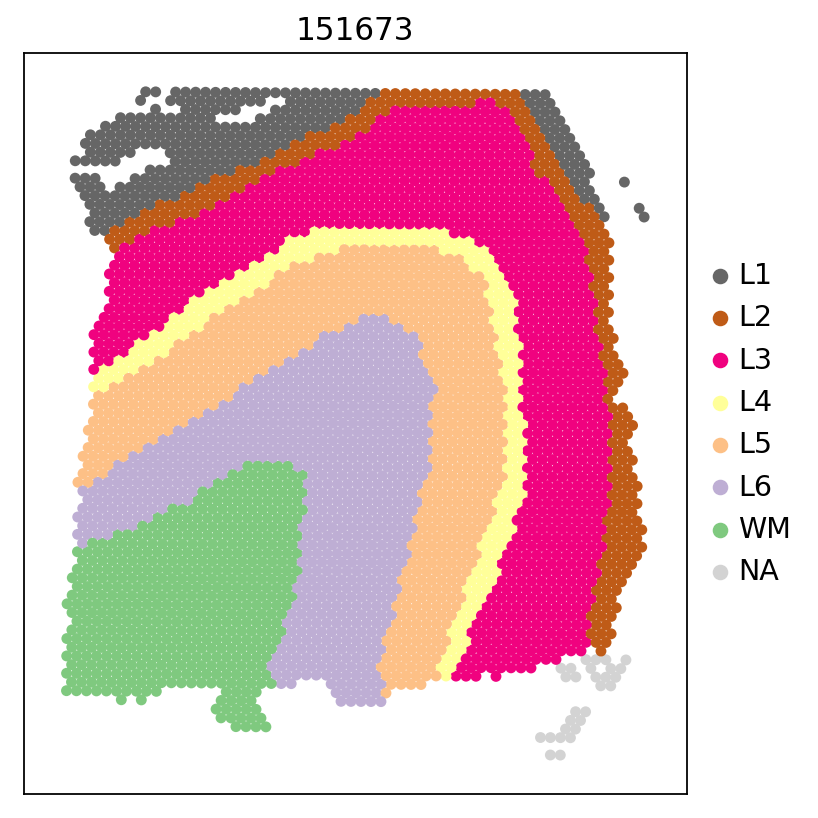

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


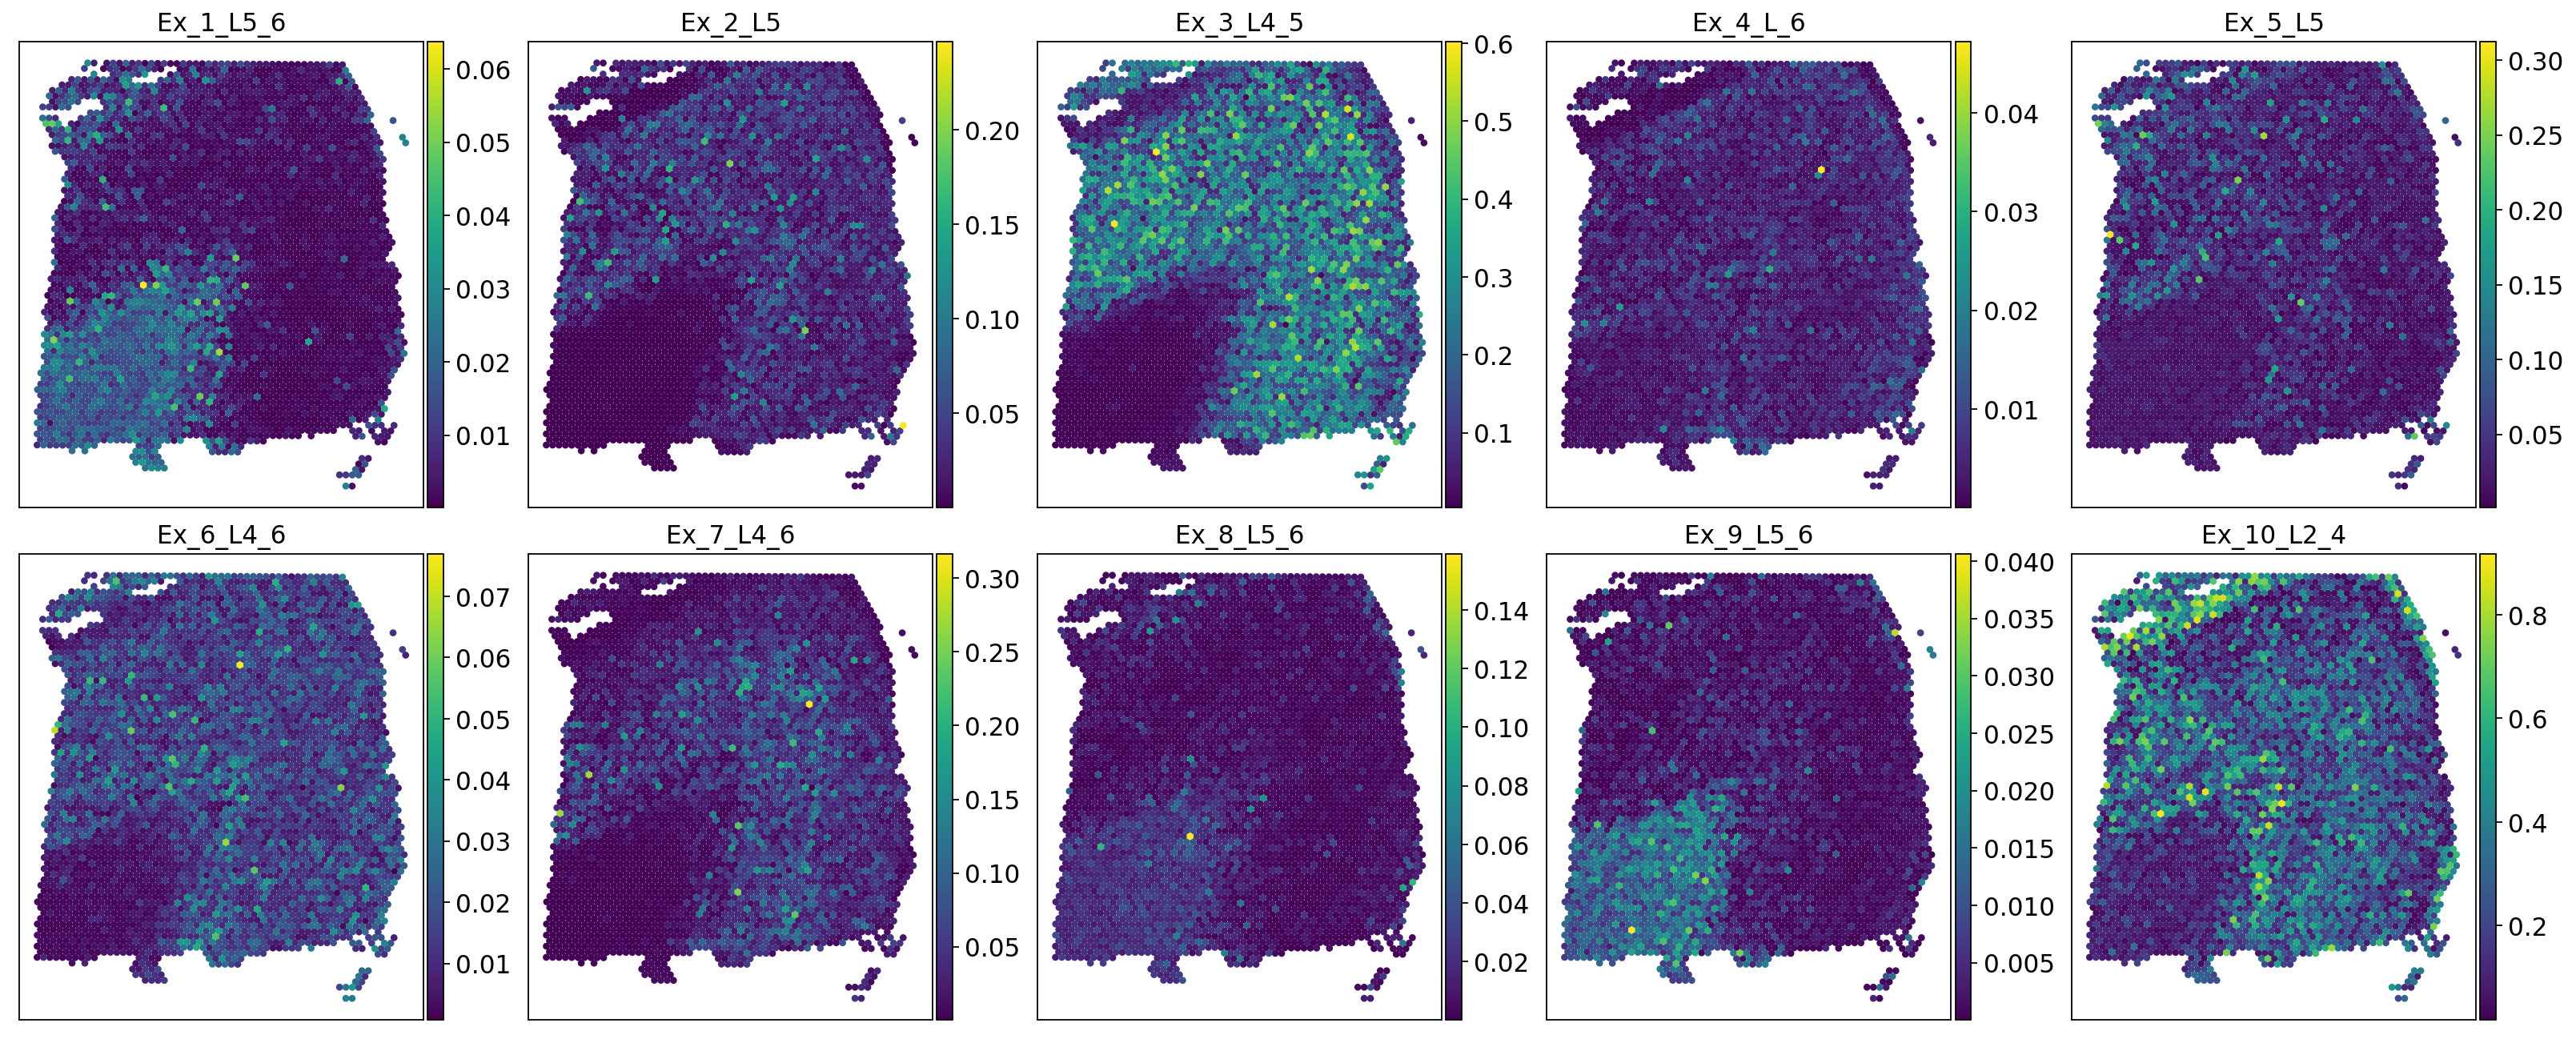

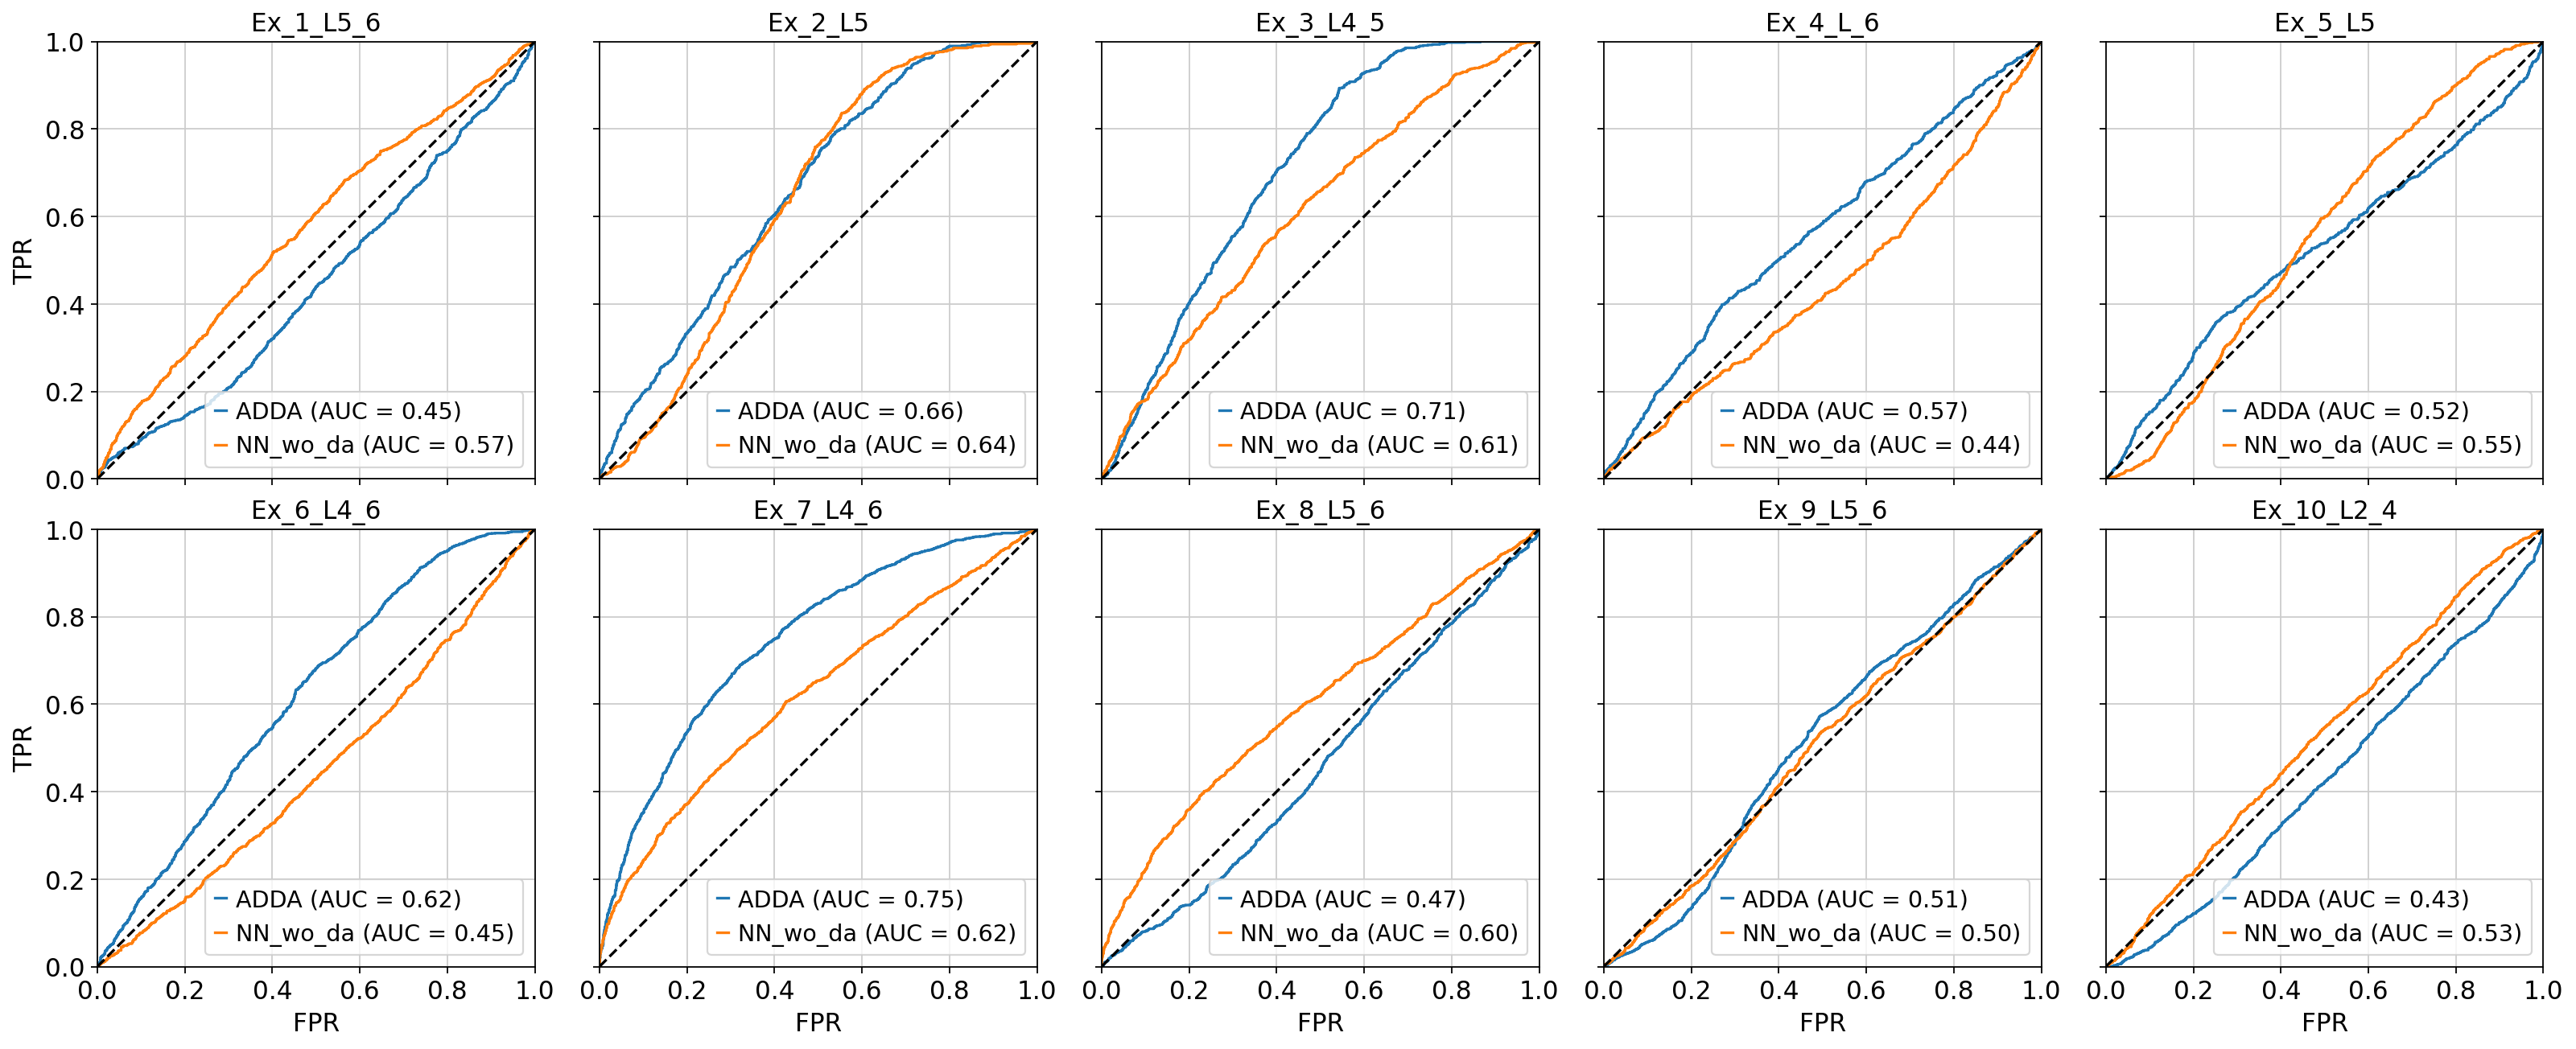

In [19]:
realspots_d = {"da": {}, "noda": {}}

for sample_id in st_sample_id_l:
    fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

    for i, num in enumerate(numlist):
        plot_cellfraction(
            num, adata_spatialLIBD_d[sample_id], pred_sp_d[sample_id], ax.flat[i]
        )
        ax.flat[i].axis("equal")
        ax.flat[i].set_xlabel("")
        ax.flat[i].set_ylabel("")

    fig.show()

    fig, ax = plt.subplots(
        2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
    )


    da_aucs = []
    noda_aucs = []
    for i, num in enumerate(numlist):
        da_aucs.append(plot_roc(
            num,
            adata_spatialLIBD_d[sample_id],
            pred_sp_d[sample_id],
            "ADDA",
            ax.flat[i],
        ))
        noda_aucs.append(plot_roc(
            num,
            adata_spatialLIBD_d[sample_id],
            pred_sp_noda_d[sample_id],
            "NN_wo_da",
            ax.flat[i],
        ))



        ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
        ax.flat[i].set_aspect("equal")
        ax.flat[i].set_xlim([0, 1])
        ax.flat[i].set_ylim([0, 1])

        ax.flat[i].set_title(f"{sc_sub_dict[num]}")

        if i >= len(numlist) - 5:
            ax.flat[i].set_xlabel("FPR")
        else:
            ax.flat[i].set_xlabel("")
        if i % 5 == 0:
            ax.flat[i].set_ylabel("TPR")
        else:
            ax.flat[i].set_ylabel("")

    realspots_d["da"][sample_id] = np.mean(da_aucs)
    realspots_d["noda"][sample_id] =  np.mean(noda_aucs)

    fig.show()


In [20]:
class JSD(nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = p.view(-1, p.size(-1)), q.view(-1, q.size(-1))
        m = (0.5 * (p + q)).log()
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

metric_ctp = JSD()

In [21]:
jsd_d = {"da": {}, "noda": {}}
for k in jsd_d:
    jsd_d[k] = {'train': {}, 'val': {}, 'test': {}}

best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

model_noda = best_checkpoint["model"]
model_noda.to(device)

model_noda.eval()
model_noda.set_encoder("source")

for sample_id in st_sample_id_l:
    if TRAIN_USING_ALL_ST_SAMPLES:
        best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
    else:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
        )

    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.set_encoder("source")

    with torch.no_grad():
        pred_mix_train = (
            model(torch.Tensor(sc_mix_train_s).to(device))
        )

        pred_mix_val = (
            model(torch.Tensor(sc_mix_val_s).to(device))
        )

        pred_mix_test = (
           model(torch.Tensor(sc_mix_test_s).to(device))
        )

        target_names = [sc_sub_dict[i] for i in range(len(sc_sub_dict))]

        
        jsd_train  = metric_ctp(torch.Tensor(lab_mix_train).to(device).log(), pred_mix_train)
        jsd_val = metric_ctp(torch.Tensor(lab_mix_val).to(device).log(), pred_mix_val)
        jsd_test = metric_ctp(torch.Tensor(lab_mix_test).to(device).log(), pred_mix_test)

        jsd_d['da']['train'][sample_id] = jsd_train #{'train': jsd_train, 'val': jsd_val, 'test': jsd_test}
        jsd_d['da']['val'][sample_id] = jsd_val
        jsd_d['da']['test'][sample_id] = jsd_test



    with torch.no_grad():
        pred_mix_train = (
            model_noda(torch.Tensor(sc_mix_train_s).to(device))
        )

        pred_mix_val = (
            model_noda(torch.Tensor(sc_mix_val_s).to(device))
        )

        pred_mix_test = (
            model_noda(torch.Tensor(sc_mix_test_s).to(device))
        )

        target_names = [sc_sub_dict[i] for i in range(len(sc_sub_dict))]

        
        jsd_train  = metric_ctp(torch.Tensor(lab_mix_train).to(device).log(), pred_mix_train)
        jsd_val = metric_ctp(torch.Tensor(lab_mix_val).to(device).log(), pred_mix_val)
        jsd_test = metric_ctp(torch.Tensor(lab_mix_test).to(device).log(), pred_mix_test)
        
        jsd_d['noda']['train'][sample_id] = jsd_train #{'train': jsd_train, 'val': jsd_val, 'test': jsd_test}
        jsd_d['noda']['val'][sample_id] = jsd_val
        jsd_d['noda']['test'][sample_id] = jsd_test

# cell_type_nums = sc_sub_dict.keys()
# nrows = ceil(len(cell_type_nums) / 5)

# line_kws = {"color": "tab:orange"}
# scatter_kws = {"s": 5}

# props = dict(facecolor="w", alpha=0.5)

# fig, ax = plt.subplots(
#     nrows,
#     5,
#     figsize=(25, 5 * nrows),
#     constrained_layout=True,
#     sharex=False,
#     sharey=True,
# )
# for i, visnum in enumerate(cell_type_nums):
#     sns.regplot(
#         x=pred_mix[:, visnum],
#         y=lab_mix_test[:, visnum],
#         line_kws=line_kws,
#         scatter_kws=scatter_kws,
#         ax=ax.flat[i],
#     ).set_title(sc_sub_dict[visnum])

#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlabel("Predicted Proportion")

#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("True Proportion")
#     else:
#         ax.flat[i].set_ylabel("")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     textstr = (
#         f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
#     )

#     # place a text box in upper left in axes coords
#     ax.flat[i].text(
#         0.95,
#         0.05,
#         textstr,
#         transform=ax.flat[i].transAxes,
#         verticalalignment="bottom",
#         horizontalalignment="right",
#         bbox=props,
#     )

# for i in range(len(cell_type_nums), nrows * 5):
#     ax.flat[i].axis("off")

# plt.show()


In [22]:
lab_mix_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09096391],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.22309431],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02076793, 0.        ,
        0.        ],
       [0.        , 0.        , 0.09833398, ..., 0.        , 0.        ,
        0.        ]])

In [23]:
nn.KLDivLoss(reduction="batchmean", log_target=True)(pred_mix_train, torch.log(torch.Tensor(lab_mix_train).to(device)))

tensor(nan, device='cuda:0')

In [24]:
nn.KLDivLoss(reduction="batchmean", log_target=True)(pred_mix_train, torch.log(torch.Tensor(lab_mix_train).to(device)))

tensor(nan, device='cuda:0')

In [25]:
lab_mix_train[0].sum()

1.0

In [26]:
rf50_d

{'da': {'train': {'151673': 0.9922568681318682},
  'val': {'151673': 0.9965659340659341},
  'test': {'151673': 0.9910714285714286}},
 'noda': {'train': {'151673': 1.0},
  'val': {'151673': 1.0},
  'test': {'151673': 1.0}}}

In [27]:
realspots_d

{'da': {'151673': 0.5681022575697893}, 'noda': {'151673': 0.5523355339926408}}